# Homework 9

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Problem 1: Corrupted MNist Dataset

The following dataset was generated by adding some images to the digits 1 and 5 images in the MNIST dataset.

In [2]:
data = pd.read_csv('mnist_corrupted.txt')

In [3]:
data = data.to_numpy()

Apply an anomaly detection method to this dataset. 
Display the images with the 100 largest anomaly scores. 
Do you see the added images?

In [4]:
def anomalyScores_proximity(X,k):
    from scipy.spatial import distance
    m,_ = X.shape
    dist = distance.squareform(distance.pdist(X)) # all pairwise distances
    neighbors = np.argsort(dist, axis=1)[:,1:k+1] # first k-nearest neighbors
    scores = np.array([np.mean(dist[i,neighbors[i]]) for i in range(m)]) # average distances 
    # scale the scores so that they are within a zero to one range
    scores = (scores-np.min(scores))/(np.max(scores)-np.min(scores))
    return scores

In [5]:
scores = anomalyScores_proximity(data,5)

In [6]:
top100 = np.sort(scores.copy())[-100:]

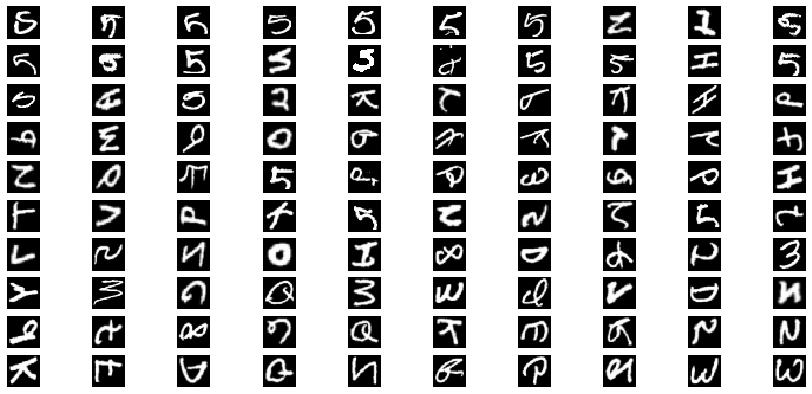

In [7]:
plt.figure(figsize=(15,7))
for j in range(100):
    digit = data[scores==top100[j]].reshape(28,28)
    plt.subplot(10, 10,j+1)
    plt.imshow(digit,cmap='gray')
    plt.axis('off')
plt.show()

## Problem 2: Node Failure in a Network of Servers

In this exercise, you will implement an anomaly detection algorithm and apply it to detect failing servers on a network

In [8]:
'load the data'
url1 = 'https://raw.githubusercontent.com/um-perez-alvaro/Anomaly-Detection/master/node_failure.csv'
url2 = 'https://raw.githubusercontent.com/um-perez-alvaro/Anomaly-Detection/master/node_failure_labels.csv'
data = pd.read_csv(url1, header = None)
labels = pd.read_csv(url2, header = None)

In [9]:
data.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,18.2710,-12.3590,5.0010,1.6115,1.0886,29.314,-8.3135,36.4380,-9.47670,-25.92800,7.1086
1,-3.1931,-19.7060,6.5286,-21.5710,3.0506,23.478,-1.1334,12.6880,-10.96800,-1.19870,1.9084
2,-5.2567,-12.9190,25.4350,-7.2316,3.6478,12.367,-6.5121,8.7509,-0.76875,-3.26110,13.7290
3,12.9530,-10.3500,19.8580,-24.4250,3.2661,30.445,-11.1260,12.8160,9.35140,-6.11360,17.6270
4,3.7638,-5.7282,11.4000,-17.5550,-6.2466,16.156,-9.7248,16.9970,-5.16870,0.18799,11.4010


Each observation is a "response" from a server.
Each observations has 11 features capturing the properties of computer servers like throughput in mb/sec and latency in milliseconds.
For this datset, we have labels for the observations, meaning we know which server responses actually heralded a server failure and are considered "anomalous".

 Part 1. Implement an anomaly detection algorithm and apply it to detect anomalous behavior of server computers on the dataset.
 Use the precision-recall curve or the F1-score to select the best anomaly-score threshold (see the Credit Card Fraud Jupyter Notebook).

In [10]:
X = data.to_numpy()
y = labels.to_numpy()
y = y[:,0]

In [11]:
def anomalyScore_PCA(X,k):
    'scale the dataset'
    means = np.mean(X,axis=0)
    stds = np.std(X,axis=0)
    X_scaled = (X-means)/stds
    'compute the singular value decomposition'
    _,_,v = np.linalg.svd(X_scaled,full_matrices=False) # singular value decomposition
    'reconstruct X_scaled based on the first k principal components'
    X_reconstructed = (X_scaled@v[:k].T)@v[:k]
    'compute anomaly scores'
    scores = np.linalg.norm(X_scaled-X_reconstructed,axis=1)
    scores = (scores-np.min(scores))/(np.max(scores)-np.min(scores))
    return scores

Text(0, 0.5, 'F1-score')

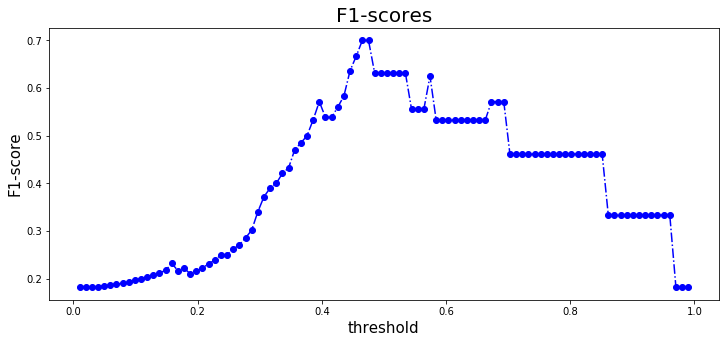

In [12]:
'compute anomaly scores'

k = 11 # number of principal components
scores = anomalyScore_PCA(X,k)
'compute F1-score for different thresholds'
threshold_list  = np.linspace(0.01,.99,100) 
F1_score = np.zeros(100) 
i = 0
for threshold in threshold_list: # try different threshold values
    # anomaly predictions
    prediction = np.zeros(len(scores))
    prediction[scores>=threshold] = 1 
    # precision and recall
    TP = np.sum(prediction[y==1]==1) # numbef of true positives
    TN = np.sum(prediction[y==0]==0) # number of true negatives
    FP = np.sum(prediction[y==0]==1) # number of false positives
    FN = np.sum(prediction[y==1]==0) # number of false negatives
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    if precision*recall!=0:
        F1_score[i] = 2*(precision*recall)/(precision+recall)
    else:
        F1_score[i]=0 # the harmonic mean is undefined if both precision and recall are zero
    i = i+1
'Plot F1-score agains threshold'
plt.figure(figsize=(12,5))
plt.plot(threshold_list,F1_score,'bo-.')
plt.title('F1-scores',fontsize=20)
plt.xlabel('threshold',fontsize=15)
plt.ylabel('F1-score',fontsize=15)

In [13]:
thresh = threshold_list[np.argmax(F1_score)]

In [14]:
y_pre = np.zeros(len(y))
y_pre[scores>thresh] = 1

In [15]:
temp = y_pre-y

temp2 = np.zeros(len(y))
correct = temp2.copy()
wrong = temp2.copy()
wrongly0 = temp2.copy()
wrongly1 = temp2.copy()

correct[temp==0] = 1
wrong[temp!=0] = 1

wrongly0[temp==-1] = 1
wrongly1[temp==1] = 1

print(sum(correct), ' correct or ', sum(correct)/len(y)*100, ' % correct')
print(sum(wrong), ' incorrect or ', sum(wrong)/len(y)*100, ' % incorrect')

print(sum(wrongly0), ' incorrectly predicted as non-Failure')
print(sum(wrongly1), ' incorrectly predicted as Failure')

94.0  correct or  94.0  % correct
6.0  incorrect or  6.0  % incorrect
3.0  incorrectly predicted as non-Failure
3.0  incorrectly predicted as Failure


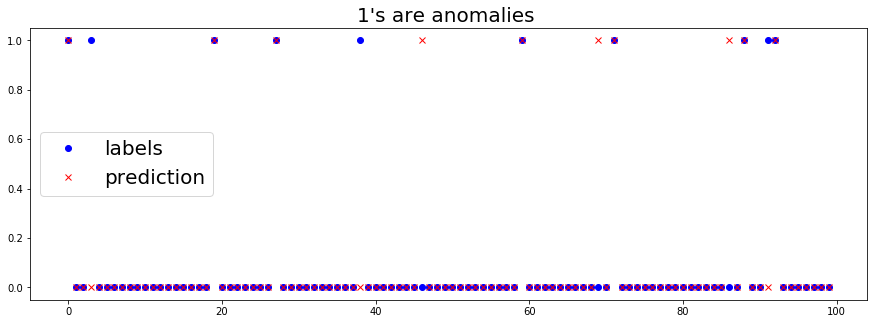

In [16]:
plt.figure(figsize=(15,5))
plt.title('1\'s are anomalies ',fontsize=20)
plt.plot(y,'bo', label='labels')
plt.plot(y_pre,'rx', label='prediction')
plt.legend(fontsize=20, loc='center left')


Part 2. Find anomalies in the following (unlabeled) dataset

In [17]:
url3 = 'https://raw.githubusercontent.com/um-perez-alvaro/Anomaly-Detection/master/node_failure_test.csv'
data_test = pd.read_csv(url3, header = None)

In [18]:
data_test.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,6.6531,13.6900,17.5530,-11.9330,-5.7564,15.4360,-12.13700,8.22410,-4.88400,5.34930,17.351000
1,-5.6305,-18.9380,18.6450,-6.1558,-25.9890,15.4100,-16.59600,9.45470,-2.87720,-6.00940,19.211000
2,9.7215,-9.9825,15.5710,-32.2240,-5.5958,24.3210,0.83277,10.79500,0.72757,10.39300,7.086000
3,-4.6358,-10.7160,20.3570,-9.0021,-4.9206,-4.2620,-1.30580,0.94998,-8.63410,0.19845,0.006771
4,-12.8410,-20.3880,9.4919,-7.0385,-9.9211,-3.7161,-9.38470,-2.32550,-13.51900,11.00700,14.003000


In [19]:
X = data_test.to_numpy()

In [20]:
'compute anomaly scores'
k = 11 # number of principal components
scores = anomalyScore_PCA(X,k)

In [21]:
y_pre = np.zeros(len(X))
y_pre[scores>thresh] = 1

Text(0.5, 1.0, "1's are prediceted failures ")

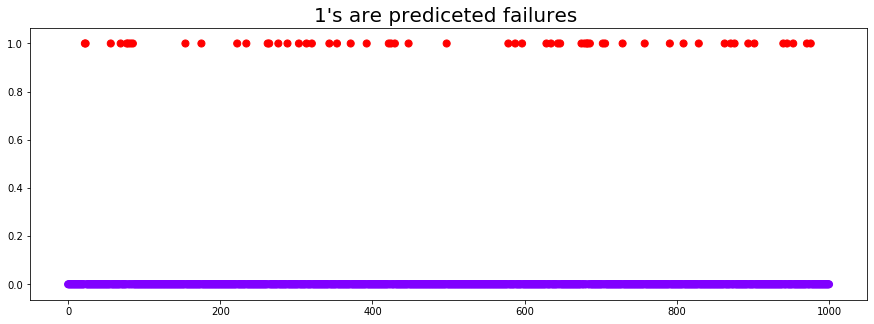

In [22]:
plt.figure(figsize=(15,5))
plt.scatter(np.linspace(0,len(X),len(X)), y_pre, s=50, c=y_pre, cmap=plt.cm.rainbow)
plt.title('1\'s are prediceted failures ',fontsize=20)

## Problem 3: Anomaly Detection Datasets

Choose three datasets from the Anomaly Detection Datasets Jupyter Notebook.
For each dataset, implement an anomaly detection algorithm.

## Problem 4: Anomaly Detection as Classification 

For each of the datasets in Problem 3, use the labels to train a classification algorithm (regression, SVD, knn, classification tree, etc). 
Does it work better than the anomaly detection algorithm?